In [51]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from math import floor, ceil
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
from os.path import exists as DoesPathExist
train_logs_path = "/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv"
train_scores_path = "/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv"
test_logs_path = "/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv"
sample_submission_path = "/kaggle/input/linking-writing-processes-to-writing-quality/sample_submission.csv"

if DoesPathExist(train_logs_path):
    train_logs: pd.DataFrame = pd.read_csv(train_logs_path)
else:
    train_logs: pd.DataFrame = pd.read_csv("./data/train_logs.csv")

if DoesPathExist(train_scores_path):
    train_scores = pd.read_csv(train_scores_path)
else:
    train_scores = pd.read_csv("./data/train_scores.csv")

if DoesPathExist(test_logs_path):
    test_logs = pd.read_csv(test_logs_path)
else:
    test_logs = pd.read_csv("./data/test_logs.csv")
    
if DoesPathExist(sample_submission_path):
    sample_submission = pd.read_csv(sample_submission_path)
else:
    sample_submission = pd.read_csv("./data/sample_submission.csv")
    
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('expand_frame_repr', False)

In [52]:
train_logs.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


In [53]:
train_scores.head()

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0


In [54]:
train_logs.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.999]).round(0)

,event_id,down_time,up_time,action_time,cursor_position,word_count
count,8405898.0,8405898.0,8405898.0,8405898.0,8405898.0,8405898.0
mean,2068.0,793560.0,793658.0,98.0,1223.0,231.0
std,1588.0,514945.0,514943.0,253.0,949.0,176.0
min,1.0,106.0,252.0,0.0,0.0,0.0
1%,35.0,47863.0,47964.0,0.0,9.0,2.0
5%,171.0,109978.0,110076.0,12.0,87.0,18.0
25%,852.0,373184.0,373282.0,66.0,499.0,96.0
50%,1726.0,720886.0,720980.0,93.0,1043.0,200.0
75%,2926.0,1163042.0,1163141.0,122.0,1706.0,327.0
95%,5121.0,1664020.0,1664111.0,176.0,3037.0,565.0


## Data Analysis

#### Score Distribution

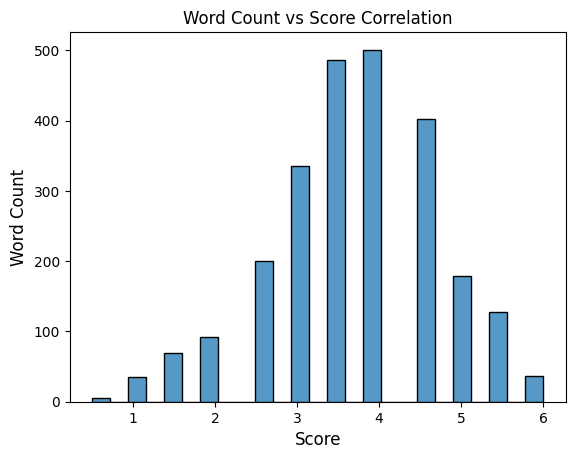

In [55]:
unique, counts = np.unique(train_scores.score, return_counts=True)
sns.histplot(data=train_scores["score"])
plt.xlabel('Score', fontsize=12)
plt.ylabel('Word Count', fontsize=12)
plt.title("Word Count vs Score Correlation")
plt.show()

#### Word Count Analysis
Here we will be looking at the effect of the word count on the outcome.

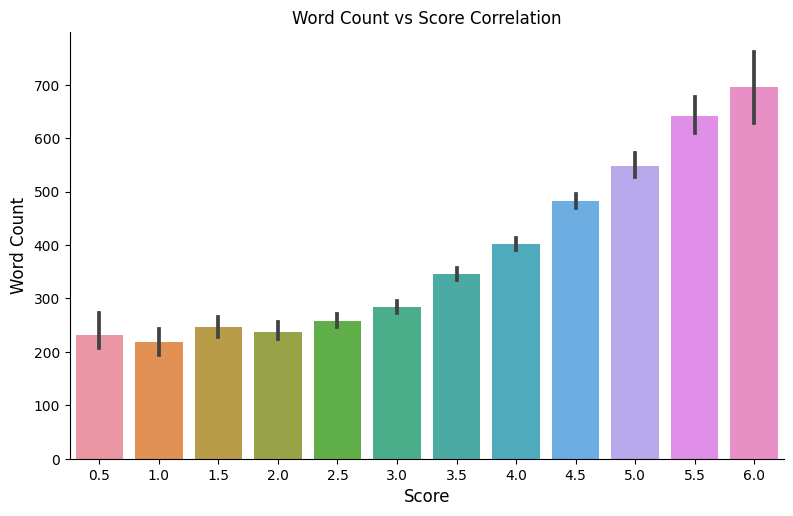

In [56]:
stats = train_logs.groupby("id")["word_count"].max().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="word_count", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Word Count', fontsize=12)
plt.title("Word Count vs Score Correlation")
plt.show()

In [57]:
stats.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).round(1)

,word_count
count,2471.0
mean,390.0
std,172.5
min,35.0
1%,199.7
5%,204.0
25%,255.0
50%,351.0
75%,480.0
95%,724.0


#### Event Analysis

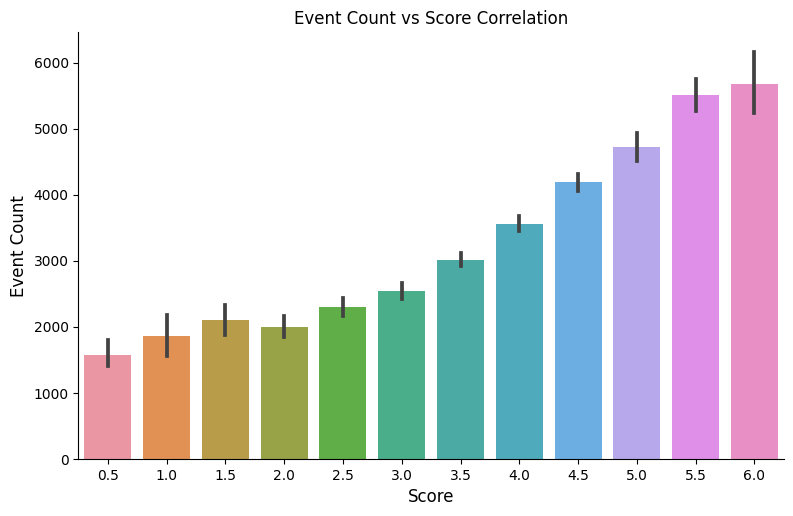

In [58]:
stats = train_logs.groupby("id")["event_id"].max().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="event_id", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Event Count', fontsize=12)
plt.title("Event Count vs Score Correlation")
plt.show()

In [59]:
stats.describe(percentiles=[0.02, 0.05, 0.25, 0.5, 0.75, 0.95, 0.98]).round(1)

,event_id
count,2471.0
mean,3401.8
std,1578.9
min,262.0
2%,1377.8
5%,1524.5
25%,2193.5
50%,3082.0
75%,4301.0
95%,6387.5


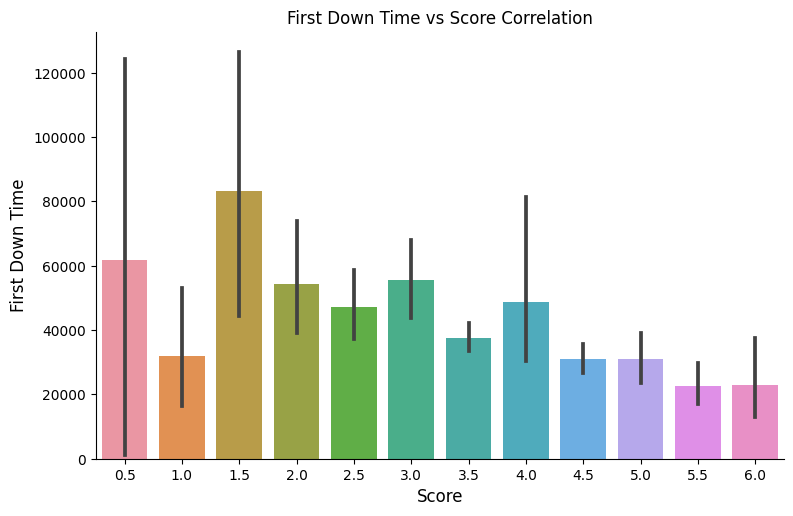

In [60]:
stats = train_logs.groupby("id")["down_time"].min().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="down_time", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('First Down Time', fontsize=12)
plt.title("First Down Time vs Score Correlation")
plt.show()

[0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6. ]
[  5  35  69  92 201 336 486 501 402 179 128  37]
[0.99797653 0.98583569 0.97207608 0.96276811 0.91865641 0.86402266
 0.80331849 0.79724808 0.83731283 0.92755969 0.94819911 0.98502631]


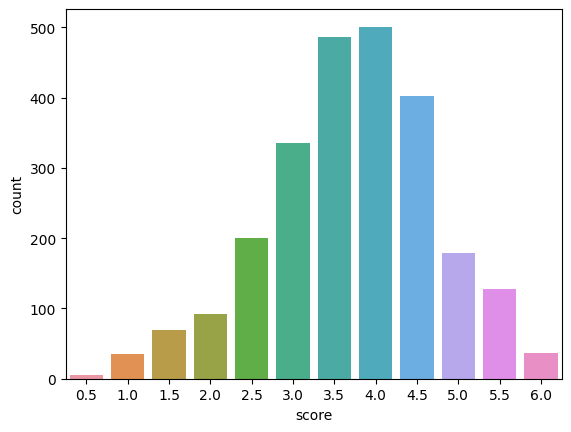

In [61]:
stats_label, stats_count = np.unique(train_scores.score, return_counts=True)
print(stats_label)
print(stats_count)
print(1 - (stats_count / 2471))
catplot = sns.barplot(x=train_scores.score.value_counts().index, y=train_scores.score.value_counts())
# plt.xlabel('Score', fontsize=12)
# plt.ylabel('First Down Time', fontsize=12)
# plt.title("First Down Time vs Score Correlation")
plt.show()

## Data preprocessing

##### Removing Outliers

In [62]:
MAX_EVENT_START_TIME = 1_800_000 # miliseconds in 30 minutes.
NUMBER_OF_INTERVALS = 1_800 # = 1_800_000 msec / 250 milisecond intervals
MAX_ACTION_TIME = 250
NUM_FEATURES = 10
PUNCUATION = ['!', '"', "'", '(', ')', ',', '.', ':', ';','?', '¡', '¿', '\\']
WORD_MAX = 800 # This is to divide all the word counts so that word count is still roughly 0-1 but keeps word count differentiable between papers.
EVENT_MAX = 6000 # Keeps Max number of event relavent but between 0-1 ish.
FINAL_LAYER_COUNT = 12

def ScoreOneHot(score: float) -> np.array:
    result = np.zeros(12)
    result[int(score / 0.5) - 1] = 1
    return result
    

def TrainingPrep(df: pd.DataFrame):

    indexs_to_drop = df[df["down_time"] > df.down_time.quantile(0.999)].index
    df.drop(indexs_to_drop, inplace=True)
    indexs_to_drop = df[df["up_time"] > df.down_time.quantile(0.999)].index
    df.drop(indexs_to_drop, inplace=True)

    return df

def DfToX(df: pd.DataFrame, score: float = None) -> np.array:
    indexs_to_drop = df[df["action_time"] > MAX_ACTION_TIME].index
    df = df.drop(indexs_to_drop, axis=0)

    NumUniqueIds = len(np.unique(df["id"]))
    x_train_1 = np.zeros((NumUniqueIds, NUM_FEATURES, int(NUMBER_OF_INTERVALS)))
    y_train = np.zeros((NumUniqueIds, FINAL_LAYER_COUNT))
    
    groups = df.groupby("id")

    for index, id in enumerate(np.unique(df["id"])):
        if score is not None:
            y_train[index] = ScoreOneHot(score)

        essayGroup = groups.get_group(id)
        max = essayGroup["down_time"].quantile(0.99)
        min = essayGroup["down_time"].quantile(0.01)
        range = max - min
        if range == 0:
            range = 1
        if range is None:
            range = 1

        MAX_CURSOR_POSITION = essayGroup["cursor_position"].max()

        if MAX_CURSOR_POSITION is None:
            print("MAX_CURSOR_POSITION is None")

        for row in essayGroup.itertuples():

            if (row.down_time < min*0.9) or (row.down_time > max*1.1):
                continue

            start_index = floor(((row.down_time - min) / range) * NUMBER_OF_INTERVALS)

            if start_index >= NUMBER_OF_INTERVALS:
                start_index = NUMBER_OF_INTERVALS - 1

            if start_index < 0:
                start_index = 0
            
            match row.activity:
                case "Nonproduction":
                    x_train_1[index][2][start_index] += 1.0
                case "Input" | "Replace":
                    # Puncuation
                    if row.down_event in PUNCUATION:
                        x_train_1[index][6][start_index] += 1.0
                    elif row.down_event == "q":
                        x_train_1[index][7][start_index] += 1.0
                    else:
                        x_train_1[index][8][start_index] += 1.0

                case "Remove/Cut":
                    x_train_1[index][4][start_index] += 1.0
                case "Paste":
                    x_train_1[index][5][start_index] += 1.0
                case _:
                    if "Move From" in row.activity:
                        x_train_1[index][3][start_index] += 1.0
            
            if x_train_1[index][0][start_index] < (row.word_count / WORD_MAX):
                x_train[index][0][start_index] = (row.word_count / WORD_MAX)
            
            if x_train_1[index][1][start_index] < (row.cursor_position / MAX_CURSOR_POSITION):
                x_train_1[index][1][start_index] = (row.cursor_position / MAX_CURSOR_POSITION)
            
            if x_train_1[index][9][start_index] < (row.event_id / EVENT_MAX):
                x_train_1[index][9][start_index] = (row.event_id / EVENT_MAX)
        
        currentWordCount = 0
        for i, wordCount in enumerate(np.nditer(x_train_1[index][0])):
            if wordCount == 0:
                x_train_1[index][0] = currentWordCount
            elif currentWordCount != wordCount:
                currentWordCount = wordCount

        currentCursorPosition = 0
        for i, cursor in enumerate(np.nditer(x_train_1[index][1])):
            if cursor == 0:
                x_train_1[index][1] = currentCursorPosition
            elif cursor != currentCursorPosition:
                currentCursorPosition = cursor

        currentEventCount = 0
        for i, event in enumerate(np.nditer(x_train_1[index][1])):
            if event == 0:
                x_train_1[index][9] = currentEventCount
            elif event != currentEventCount:
                currentEventCount = event
                
    x_train_1 = np.transpose(x_train_1, axes=(0, 2, 1))
    return x_train_1, y_train

def GenerateNewExample(x_train: np.array):
    example_index = np.random.choice(len(x_train), 1)[0]
    Noise = (0.005 * np.random.sample(x_train[0].shape)) - 0.0025
    result = x_train[example_index] *  (1 + Noise)
    return result

In [63]:
NUM_EXAMPLES_UPPER_LIMIT = 1000
NUM_EXAMPLES_LOWER_LIMIT = 50
TrainingPrep(train_logs)

x_train = np.zeros((0, int(NUMBER_OF_INTERVALS), NUM_FEATURES))
y_train = np.zeros((0, FINAL_LAYER_COUNT))

x_valid = np.zeros((0, int(NUMBER_OF_INTERVALS), NUM_FEATURES))
y_valid = np.zeros((0, FINAL_LAYER_COUNT))

x_test = np.zeros((0, int(NUMBER_OF_INTERVALS), NUM_FEATURES))
y_test = np.zeros((0, FINAL_LAYER_COUNT))

for x in range(1, 13):
    ids = train_scores[train_scores["score"] == (x/2)]
    temp_train_x, temp_train_y = DfToX(train_logs[train_logs["id"].isin(ids.id)], x/2)

    if len(temp_train_x) > NUM_EXAMPLES_UPPER_LIMIT:
        np.random.shuffle(temp_train_x)
        temp_train_x = temp_train_x[:NUM_EXAMPLES_UPPER_LIMIT]
        temp_train_y = temp_train_y[:NUM_EXAMPLES_UPPER_LIMIT]
    
    while len(temp_train_x) < NUM_EXAMPLES_LOWER_LIMIT:
        randomExample = GenerateNewExample(x_train=temp_train_x)
        temp_train_x = np.concatenate((temp_train_x, [randomExample]))
        temp_train_y = np.concatenate((temp_train_y, [temp_train_y[0]]))

    first_cutoff = floor(0.2 * len(temp_train_x))
    second_cutoff = first_cutoff * 2
    x_test = np.append(x_test, temp_train_x[:first_cutoff], axis=0)
    x_valid = np.append(x_valid, temp_train_x[first_cutoff:second_cutoff], axis=0)
    x_train = np.append(x_train, temp_train_x[second_cutoff:], axis=0)

    y_test = np.append(y_test, temp_train_y[:first_cutoff], axis=0)
    y_valid = np.append(y_valid, temp_train_y[first_cutoff:second_cutoff], axis=0)
    y_train = np.append(y_train, temp_train_y[second_cutoff:], axis=0)

In [64]:
print(f"Shape of X Train: {x_train.shape}")
print(f"Shape of Y Train: {y_train.shape}\n")
print(f"Shape of X Valid: {x_valid.shape}")
print(f"Shape of Y Valid: {y_valid.shape}\n")
print(f"Shape of X Test: {x_test.shape}")
print(f"Shape of Y Test: {y_test.shape}\n")

Shape of X Train: (1533, 1800, 10)
Shape of Y Train: (1533, 12)

Shape of X Valid: (505, 1800, 10)
Shape of Y Valid: (505, 12)

Shape of X Test: (505, 1800, 10)
Shape of Y Test: (505, 12)



In [65]:
input_shape = (len(x_train), len(x_train[0]), len(x_train[0][0]))
print(input_shape)

model: tf.keras.models.Sequential = models.Sequential()
model.add(layers.InputLayer(input_shape=input_shape[1:], dtype=np.float64))
model.add(layers.Normalization())

model.add(layers.Conv1D(filters=128, kernel_size = (16,), strides=2, padding="SAME", activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.AveragePooling1D())

model.add(layers.Conv1D(filters=12, kernel_size = (8,), strides=1, padding="SAME", activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.MaxPooling1D())

model.add(layers.Conv1D(filters=12, kernel_size = (4,), strides=1, padding="SAME", activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))

model.add(layers.Flatten())

model.add(layers.Dense(units=256,activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(units=12,activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=12,activation=tf.keras.activations.softmax))
model.summary()

(1533, 1800, 10)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normaliza  (None, 1800, 10)          21        
 tion)                                                           
                                                                 
 conv1d_9 (Conv1D)           (None, 900, 128)          20608     
                                                                 
 average_pooling1d_3 (Avera  (None, 450, 128)          0         
 gePooling1D)                                                    
                                                                 
 conv1d_10 (Conv1D)          (None, 450, 12)           12300     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 225, 12)           0         
 g1D)                                                            
                                     

In [66]:
unique_scores, unique_scores_count = np.unique(train_scores.score, return_counts=True)
loss_weights = [x for x in ( 1 - (stats_count / len(y_train)))]
#loss_weights = [1 for x in range(12)]
print(len(loss_weights))
print(loss_weights)

metrics = [tf.keras.metrics.categorical_accuracy,
          tf.keras.metrics.CategoricalCrossentropy(), 
        #    tf.keras.metrics.OneHotIoU(12, [x for x in range(12)]),
        #    tf.keras.metrics.OneHotMeanIoU(12)
        ]
model.compile(optimizer='adam', 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=metrics,
              loss_weights=loss_weights
            )

12
[0.9967384213959556, 0.9771689497716896, 0.9549902152641878, 0.9399869536855838, 0.8688845401174168, 0.7808219178082192, 0.6829745596868885, 0.6731898238747553, 0.7377690802348337, 0.8832354859752121, 0.9165035877364645, 0.9758643183300717]


In [67]:
epochs = 10
history = model.fit(x=x_train, y=y_train, validation_data=(x_valid,y_valid), epochs=epochs)

Epoch 1/10
48/48 [==============================] - 2s 41ms/step - loss: 2.7215 - categorical_accuracy: 0.1846 - categorical_crossentropy: 2.3303 - val_loss: 2.5010 - val_categorical_accuracy: 0.1980 - val_categorical_crossentropy: 2.2102
Epoch 2/10
48/48 [==============================] - 2s 39ms/step - loss: 2.4331 - categorical_accuracy: 0.2055 - categorical_crossentropy: 2.1941 - val_loss: 2.3484 - val_categorical_accuracy: 0.2277 - val_categorical_crossentropy: 2.1529
Epoch 3/10
48/48 [==============================] - 2s 42ms/step - loss: 2.2583 - categorical_accuracy: 0.2250 - categorical_crossentropy: 2.0897 - val_loss: 2.2227 - val_categorical_accuracy: 0.1960 - val_categorical_crossentropy: 2.0773
Epoch 4/10
48/48 [==============================] - 2s 40ms/step - loss: 2.0976 - categorical_accuracy: 0.2844 - categorical_crossentropy: 1.9645 - val_loss: 2.1585 - val_categorical_accuracy: 0.2238 - val_categorical_crossentropy: 2.0370
Epoch 5/10
48/48 [==========================

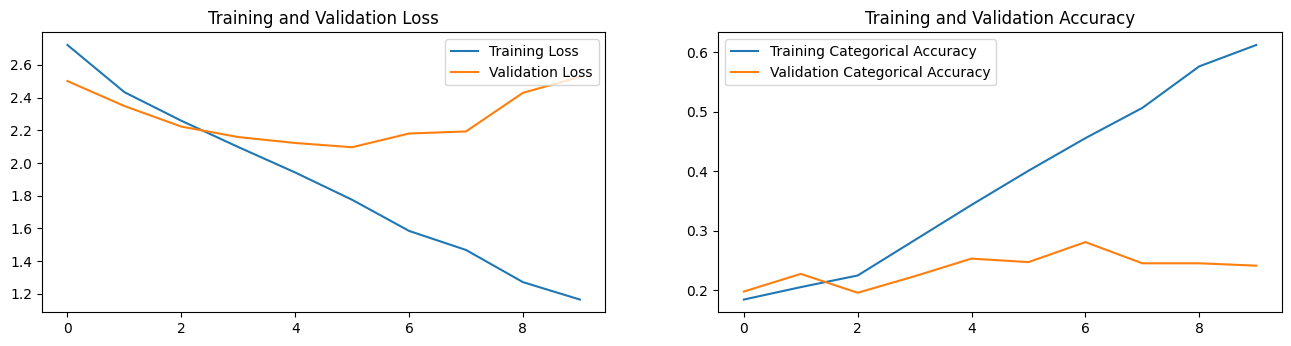

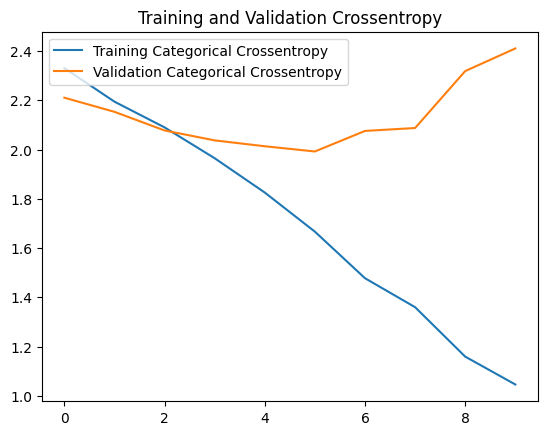

In [68]:
epochs_range = range(epochs)

loss = history.history['loss']
val_loss = history.history['val_loss']
fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(2, 2, 1)
#ax.set_ylim(0, 3)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

CatAccuracy = history.history['categorical_accuracy']
val_CatAccuracy = history.history['val_categorical_accuracy']
ax = fig.add_subplot(2, 2, 2)
#ax.set_ylim(0, 3)
plt.plot(epochs_range, CatAccuracy, label='Training Categorical Accuracy')
plt.plot(epochs_range, val_CatAccuracy, label='Validation Categorical Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')
plt.show()

Crossentropy = history.history['categorical_crossentropy']
val_Crossentropy = history.history['val_categorical_crossentropy']
ax = fig.add_subplot(2, 2, 3)
plt.plot(epochs_range, Crossentropy, label='Training Categorical Crossentropy')
plt.plot(epochs_range, val_Crossentropy, label='Validation Categorical Crossentropy')
plt.legend(loc='upper left')
plt.title('Training and Validation Crossentropy')


plt.show()



In [69]:
def OneColdCode(arr: list) -> float:
    score = 0.5
    max_score = 0.5
    highests = 0
    for i in arr:
        if i >= highests:
            highests = i
            max_score = score
        score += 0.5
    return max_score

def HalfRound(a: float) -> float:
    return round(a * 2) / 2.0

16/16 [==============================] - 0s 11ms/step


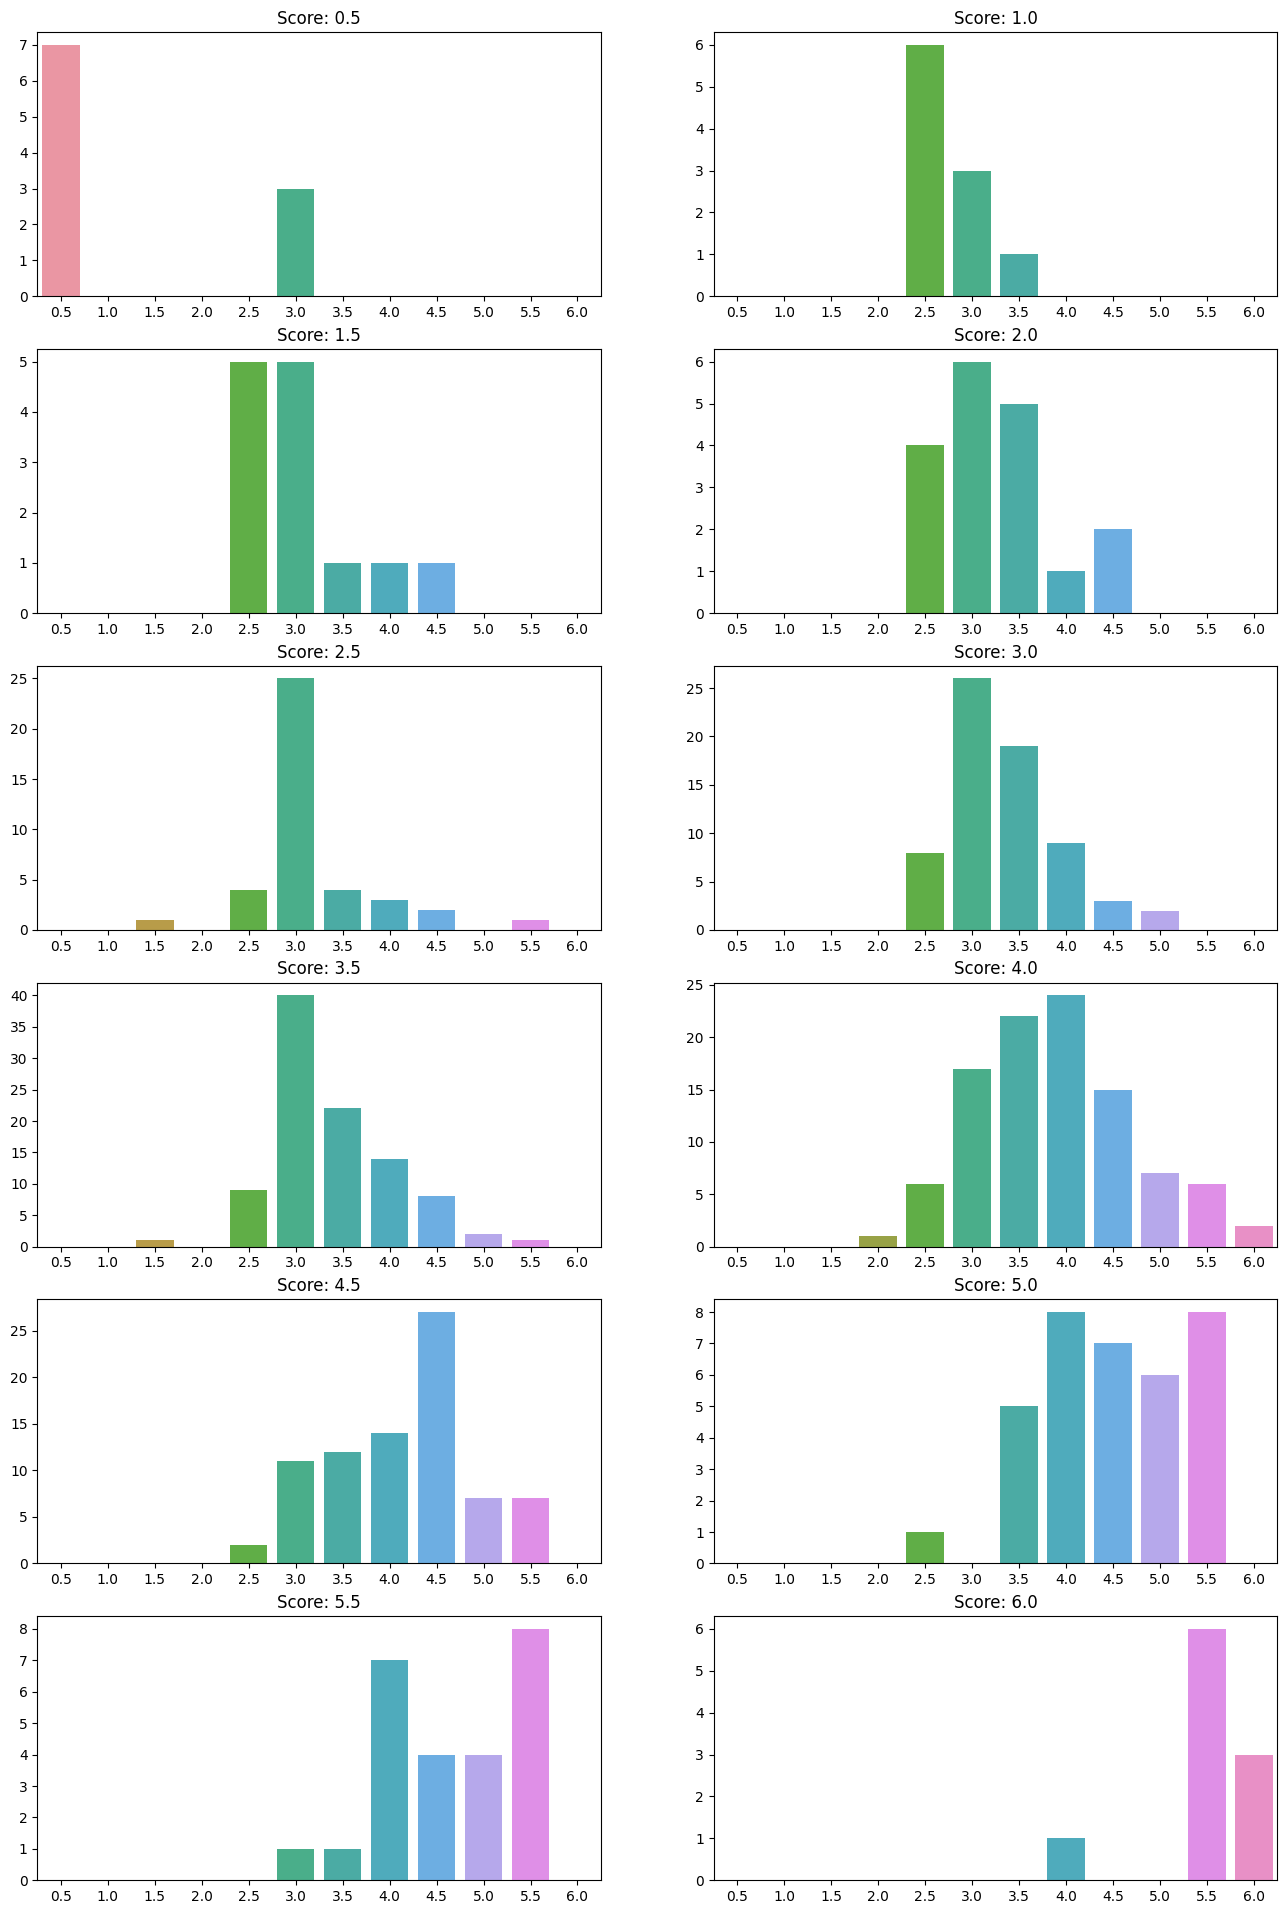

In [71]:
model.evaluate(x_test, y_test)
test_predictions = model.predict(x_test)
test_predictions = [OneColdCode(x) for x in test_predictions]
actual_values = np.array([OneColdCode(y) for y in y_test])

fig = plt.figure(figsize=(16, 24))
for i in range(1, 13, 1):
    count = np.zeros(12)

    for index, value in enumerate(actual_values):
        if value == i/2:
            count[int(test_predictions[index] * 2) - 1] += 1

    fig.add_subplot(6, 2, i)
    sns.barplot(x=[x/2 for x in range(1, 13)], y=count)
    plt.title(f'Score: {i/2}')

plt.show() 
test_predictions = pd.DataFrame({"y" : test_predictions, })

In [ ]:
# 2c75e15a --> 4.0
# 2c7997a3 --> 3.5
# 2d299968 --> 5.0
test_logs = pd.read_csv("./data/personaltest.csv")

predictions = []
for id in test_logs["id"].unique():
    pred_score = 3.5
    try:
        x_test, y_test = DfToX(test_logs[test_logs["id"] == id])
        pred = model.predict(x_test)
        pred_score = OneColdCode(pred[0])
        #pred_score = HalfRound(pred[0][0])
        #pred_score = pred[0][0]
    except ValueError as ex:
        pred_score = 3.5
        print(f"VALUE ERROR OCCURED. ERROR: {ex}")
    except Exception as ex:
        print(f"ERROR: {ex}")
        pred_score = 3.5
    finally:
        predictions.append((id, pred_score))

ids = [p[0] for p in predictions]
scores = [p[1] for p in predictions]

sample_submission["id"] = ids
sample_submission["score"] = scores
sample_submission[["id", "score"]].to_csv("submission.csv", index=False)

In [ ]:
try:
    personal_test_logs = pd.read_csv("./data/personaltest.csv")
    personal_ids = np.unique(personal_test_logs.id)
    personal_test_scores = train_scores[train_scores["id"].isin(personal_ids)]
    personal_test_logs = TrainingPrep(personal_test_logs)
    personal_x_test, personal_y_test = DfToX(personal_test_logs, personal_test_scores)

    model.evaluate(personal_x_test, personal_y_test)

    personal_predictions = model.predict(personal_x_test)
    for p in personal_predictions:
        print(p)

    personal_predictions = [OneColdCode(x) for x in personal_predictions]
    personal_predictions = pd.DataFrame({"y" : personal_predictions, "x" : np.array([OneColdCode(y) for y in personal_y_test])})

    sns.relplot(
        data=personal_predictions, x="x", y="y"
    )
except Exception as ex:
    print(f"Test box: {ex})")